# ANDES interface with pandapower

This example (1) shows how to convert an ANDES system (`ssa`) to a pandapower network (`ssp`), (2) benchmarks the powerflow results, (3) shows how to alter `ssa` active power setpoints according to `ssp` results.

In [1]:
import andes
from andes.utils.paths import get_case
from andes.io.pandapower import to_pandapower, ssa_link, opp_res, ssp_cost
andes.config_logger(stream_level=20)

import pandapower as pp
import numpy as np
import pandas as pd

from math import pi

## Load case

Here we use the same ANDES system `ss0` to do the pandapower conversion, which leaves the `ssa` untouched.

This will be useful if you need to modify the `ssa` parametes or setpoints.

In [2]:
ssa = andes.load(get_case('ieee14/ieee14_ieeet1.xlsx'),
                 setup=False,
                 no_output=True,
                 default_config=True)
ssa.Toggler.u.v = [0, 0]
ssa.setup()

ss0 = andes.load(get_case('ieee14/ieee14_ieeet1.xlsx'),
                 setup=False,
                 no_output=True,
                 default_config=True)
ss0.Toggler.u.v = [0, 0]
ss0.setup()

Working directory: "/Users/jinningwang/Documents/work/andes/examples"
Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Parsing input file "/Users/jinningwang/Documents/work/andes/andes/cases/ieee14/ieee14_ieeet1.xlsx"...
Input file parsed in 0.2353 seconds.
System internal structure set up in 0.0537 seconds.
Working directory: "/Users/jinningwang/Documents/work/andes/examples"
Reloaded generated Python code of module "pycode".
Parsing input file "/Users/jinningwang/Documents/work/andes/andes/cases/ieee14/ieee14_ieeet1.xlsx"...
Input file parsed in 0.0876 seconds.
System internal structure set up in 0.0526 seconds.


True

## Convert to pandapower net

Convert ADNES system `ssa` to pandapower net `ssp`.

In [3]:
ssp = to_pandapower(ss0)

System has been setup. Calling setup twice is not allowed.
-> System connectivity check results:
  No islanded bus detected.
  A total of 1 island(s) detected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0050 seconds.
0: |F(x)| = 0.5605182134
1: |F(x)| = 0.006202200332
2: |F(x)| = 5.819382825e-06
3: |F(x)| = 6.967745825e-12
Converged in 4 iterations in 0.0110 seconds.


Power flow are consistent, conversion is successful.


Add generator cost data.

In [4]:
gen_cost = np.array([
        [2, 0, 0, 3, 0.0430293, 20, 0], 
        [2, 0, 0, 3, 0.25,      20, 0], 
        [2, 0, 0, 3, 0.01,      40, 0], 
        [2, 0, 0, 3, 0.01,      40, 0], 
        [2, 0, 0, 3, 0.01,      40, 0]
])

ssp_cost(ssp, gen_cost)

True

Inspect the pandapower net `ssp`.

In [5]:
ssp

This pandapower network includes the following parameter tables:
   - bus (14 elements)
   - load (11 elements)
   - gen (5 elements)
   - shunt (2 elements)
   - line (16 elements)
   - trafo (4 elements)
   - poly_cost (5 elements)
 and the following results tables:
   - res_bus (14 elements)
   - res_line (16 elements)
   - res_trafo (4 elements)
   - res_load (11 elements)
   - res_shunt (2 elements)
   - res_gen (5 elements)

## Comapre Power Flow

Run power flow of `ssa`.

In [6]:
ssa.PFlow.run()

-> System connectivity check results:
  No islanded bus detected.
  A total of 1 island(s) detected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0066 seconds.
0: |F(x)| = 0.5605182134
1: |F(x)| = 0.006202200332
2: |F(x)| = 5.819382825e-06
3: |F(x)| = 6.967745825e-12
Converged in 4 iterations in 0.0085 seconds.


True

In [7]:
# ssa
ssa_res_gen = pd.DataFrame(columns=['name', 'p_mw', 'q_mvar', 'va_degree', 'vm_pu'])
ssa_res_gen['name'] = ssa.PV.as_df()['name']
ssa_res_gen['p_mw'] = ssa.PV.p.v * ssa.config.mva
ssa_res_gen['q_mvar'] = ssa.PV.q.v * ssa.config.mva
ssa_res_gen['va_degree'] = ssa.PV.a.v * 180 / pi
ssa_res_gen['vm_pu'] = ssa.PV.v.v
ssa_res_slack = pd.DataFrame([[ssa.Slack.name.v[0], ssa.Slack.p.v[0] * ssa.config.mva,
                              ssa.Slack.q.v[0] * ssa.config.mva, ssa.Slack.a.v[0] * 180 / pi,
                              ssa.Slack.v.v[0]]],
                             columns=ssa_res_gen.columns,
                             )
ssa_res_gen = pd.concat([ssa_res_gen, ssa_res_slack]).reset_index(drop=True)

# ssp
pp.runpp(ssp)
ssp_res_gen = pd.concat([ssp.gen['name'], ssp.res_gen], axis=1)

pf_gen = pd.concat([ssa_res_gen, ssp_res_gen], axis=1)

pf_bus = ssa.Bus.as_df()[["name"]].copy()
# ssa
pf_bus['v_ad'] = ssa.Bus.v.v
pf_bus['a_ad'] = ssa.Bus.a.v * 180 / pi

# ssp
pf_bus['v_pp'] = ssp.res_bus['vm_pu']
pf_bus['a_pp'] = ssp.res_bus['va_degree']

### Generation

In [8]:
pf_gen.round(4)

,name,p_mw,q_mvar,va_degree,vm_pu,name,p_mw,q_mvar,va_degree,vm_pu
0,2,40.0000,30.4361,-1.7641,1.03,2,40.0000,30.4361,-1.7641,1.03
1,3,40.0000,12.5971,-3.5371,1.01,3,40.0000,12.5971,-3.5371,1.01
2,4,30.0000,20.9866,-6.4527,1.03,4,30.0000,20.9866,-6.4527,1.03
3,5,35.0000,7.3964,-1.5400,1.03,5,35.0000,7.3964,-1.5400,1.03
4,1,81.4272,-21.6171,0.0000,1.03,1,81.4272,-21.6171,0.0000,1.03


### Bus voltage and angle

In [9]:
pf_bus.round(4)

,name,v_ad,a_ad,v_pp,a_pp
uid,,,,,
0,BUS1,1.0300,0.0000,1.0300,0.0000
1,BUS2,1.0300,-1.7641,1.0300,-1.7641
2,BUS3,1.0100,-3.5371,1.0100,-3.5371
3,BUS4,1.0114,-4.4098,1.0114,-4.4098
4,BUS5,1.0173,-3.8430,1.0173,-3.8430
5,BUS6,1.0300,-6.4527,1.0300,-6.4527
6,BUS7,1.0225,-4.8852,1.0225,-4.8852
7,BUS8,1.0300,-1.5400,1.0300,-1.5400
8,BUS9,1.0218,-7.2459,1.0218,-7.2459


## Dispatch based on ``ssp`` results

Prepare the `ssa_key` table.

In [10]:
# Asign the StaticGen with OPF, in this case, all the SynGen are GENROU
ssa_key = ssa_link(ssa)

Run the TDS in ADNES to 2s.


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-2 s.
Fixed step size: h=33.33 ms. Shrink if not converged.
Initialization for dynamics completed in 0.0611 seconds.
Initialization was successful.


 65%|###########################3              | 65/100 [00:00<00:00, 651.87%/s]

Simulation completed in 0.1003 seconds.


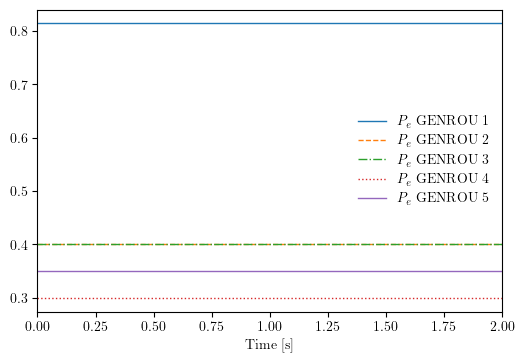

(<Figure size 600x400 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [11]:
ssa.TDS.config.tf = 2
ssa.TDS.run()

ssa.TDS.plt.plot(ssa.GENROU.Pe)

Get the OPF results from pandapower. The `ssp_res` has beed converted to p.u..

In [12]:
ssp_res = opp_res(ssp, ssa_key)
ssp_res

,name,p,q,vm_pu,bus,bus_name,gov_idx,stg_idx,exc_idx
0,2,0.500000,0.129214,1.096908,1,BUS2,TGOV1_2,2,EXST1_1
1,3,0.412728,0.149999,1.082554,2,BUS3,TGOV1_3,3,ESST3A_3
2,4,0.343962,0.099999,1.086078,5,BUS6,TGOV1_4,4,ESST3A_4
3,5,0.496196,0.085231,1.099999,7,BUS8,TGOV1_5,5,1
4,1,0.500000,-0.079092,1.100000,0,BUS1,TGOV1_1,1,ESST3A_2


Now dispatch the resutls into `ssa`, where the active power setpoitns are updated to `TurbinGov.pref0`.

In [13]:
ssa_gov_idx = list(ssp_res['gov_idx'][~ssp_res['gov_idx'].isna()])
ssa.TurbineGov.set(src='pref0', idx=ssa_gov_idx, attr='v', value=ssp_res['p'][~ssp_res['gov_idx'].isna()])
ssa.TurbineGov.get(src='pref0', idx=ssa_gov_idx, attr='v')

array([0.49999999, 0.41272757, 0.34396221, 0.49619557, 0.50000009])

Now run the TDS to 50s.

In [14]:
ssa.TDS.config.tf = 50
ssa.TDS.run()

100%|########################################| 100.0/100 [00:04<00:00, 23.66%/s]

Simulation completed in 4.2277 seconds.


True

We can see the outputs of `GENROU` are rearranged by the OPF results.

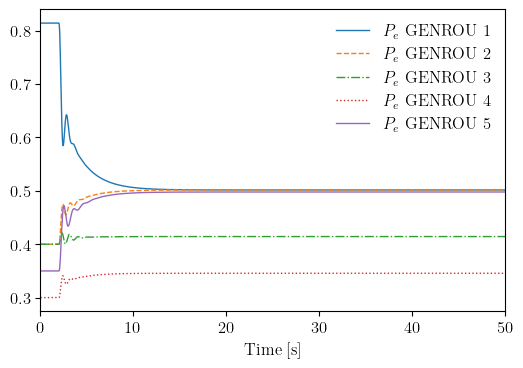

(<Figure size 600x400 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [15]:
ssa.TDS.plt.plot(ssa.GENROU.Pe)